# Best paintings of all time classification task

We want to classify the best paintings of all time. We will use a dataset of paintings and their respective artists. We will extract features from the images and then we will train a classifier to predict the artists genre of the painting.

In [1]:
import numpy as np
import pandas as pd 
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import legacy  # Use legacy optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.metrics as Metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import unicodedata
import re 

## Data exploration and analysis

In [2]:
np.random.seed(7)
general = pd.read_csv('artists.csv')
artists = general[['name','paintings']]
artists = artists.sort_values(by=['paintings'],ascending=False)

In [3]:
def plot_artist_images(artist_name: str, image_directory: str, img_dim=(128, 128), grid_size=(5, 5)):
    print(artist_name)
    all_files = os.listdir(image_directory)
    normalized_artist_name = artist_name.replace(' ', '_').lower()
    image_files = [file for file in all_files if normalized_artist_name in file.lower() and file.lower().endswith(('.jpg'))]
    
    print(f"Total number of images: {len(image_files)}")
    
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    for index, image_path in enumerate(image_files[:3]):
        img_path = os.path.join(image_directory, image_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_dim)
        plt.subplot(grid_size[0], grid_size[1], index + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

Paul Cezanne
Total number of images: 47


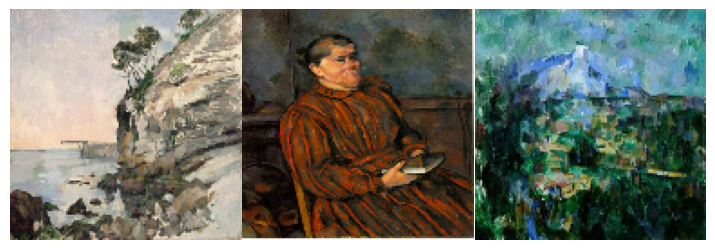

In [4]:
images_directory= './paintings'
images = os.listdir('./paintings')
artist_name = 'Paul Cezanne'
plot_artist_images(artist_name, images_directory)

Andy Warhol
Total number of images: 181


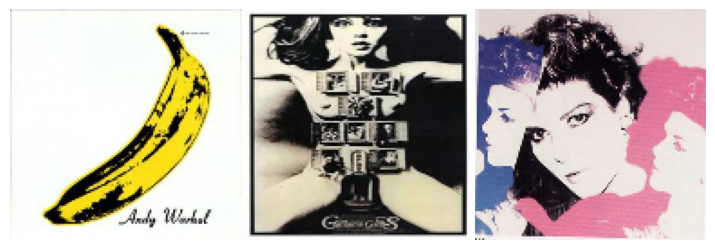

In [5]:
plot_artist_images('Andy Warhol', images_directory)

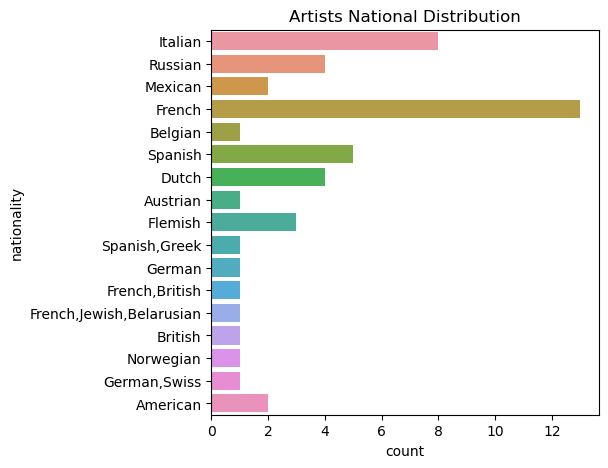

In [6]:
plt.figure(figsize=(5,5))
nationalities = sns.countplot(y='nationality',data=general)
nationalities.set_title('Artists National Distribution')
plt.show()

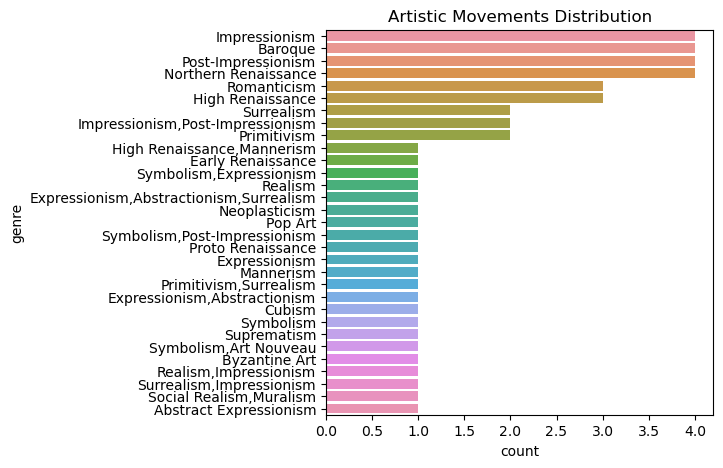

In [7]:
plt.figure(figsize=(5,5))
nationalities = sns.countplot(y='genre' ,data=general, order = general['genre'].value_counts().index)
nationalities.set_title('Artistic Movements Distribution')
plt.show()

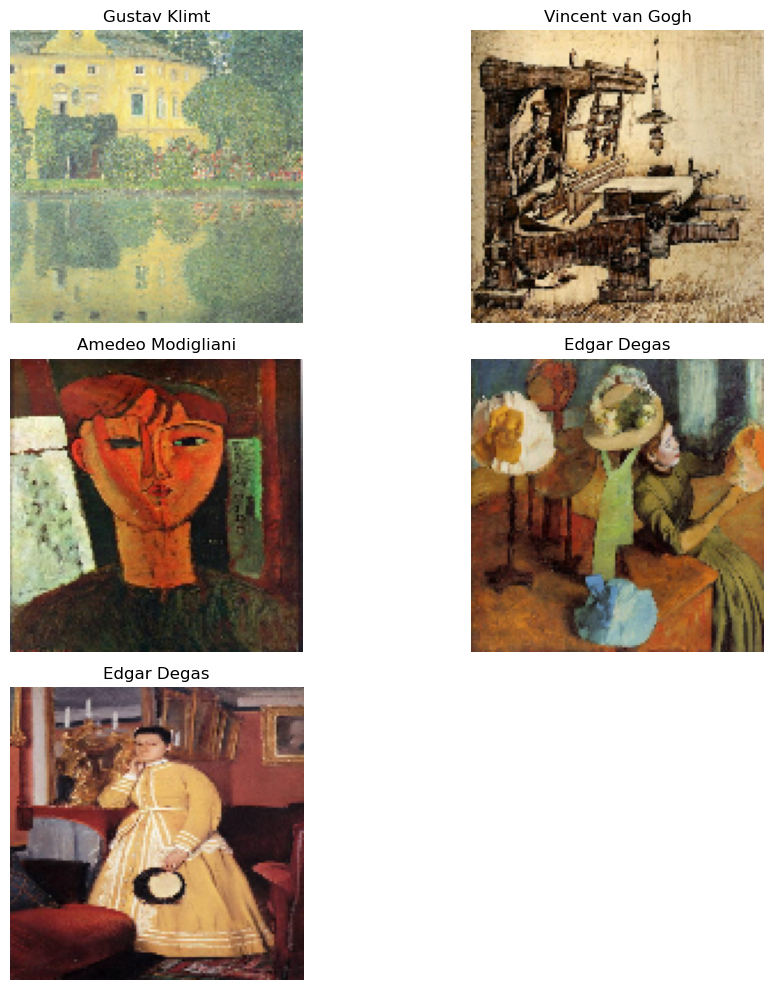

In [8]:
num_paintings = 5
all_files = os.listdir(images_directory)
image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

plt.figure(figsize=(10, 10)) 

for i, filename in enumerate(image_files[:num_paintings]):
    artist_name = ' '.join(filename.split('_')[:-1]).replace('_', ' ')
    img_path = os.path.join(images_directory, filename)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
        
    ax = plt.subplot((num_paintings + 1) // 2, 2, i + 1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(artist_name)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [9]:
#To normalize the names of the artists
def normalize_name(name):
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    return name.replace(' ', '_')


To load the other informations regarding the painters and preprocessing the data:

In [10]:
def load_and_preprocess_data(image_directory, csv_path):

    artist_df = pd.read_csv(csv_path)
    artist_info = {}
    for index, row in artist_df.iterrows():
        artist_key = normalize_name(row['name']).replace(' ', '_') # to get the name of the artist and normalize it
        artist_info[artist_key] = {
            'name': row['name'],
            'genre': row['genre'],
            'nationality': row['nationality']
        }

    features = []
    labels = []
    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg"):
            artist_id_parts = filename.rsplit('_', 1)[0]  # Remove the last part (usually a number and extension)
            artist_key = normalize_name(artist_id_parts)  # Normalize the artist key

            if artist_key in artist_info:
                img_path = os.path.join(image_directory, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    #here we resize the image to 128x128 for the model
                    img = cv2.resize(img, (128, 128))
                    features.append(img)
                    labels.append(artist_info[artist_key]['genre'])
            else:
                print(f"Missing artist info for ID: {artist_key}, Filename: {filename}")
    
    features = np.array(features)
    labels = np.array(labels)
    return features, labels


X, y = load_and_preprocess_data(images_directory, 'artists.csv')

In [11]:
# Regular expression that matches labels to keep combined in this regex keeps labels with two capital words joined by a comma
combined_pattern = re.compile(r'\b[A-Z][a-z]+,[A-Z][a-z]+\b')

# Function to process each label
def process_labels(label):
    if combined_pattern.match(label):
        return[label]
    else:
        return label.split(',')

Here we encode the labels using `MultiLabelBinarizer()` We will use the encoded labels to train the model;

In [12]:
y_processed = [process_labels(label) for label in y]
print("Processed labels:", y_processed[:5])  # Print the first 5 for checking

mlb_genre = MultiLabelBinarizer()

mlb_genre.fit(y_processed)
print(mlb_genre.classes_)
y_transformed = mlb_genre.transform(y_processed)

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=7)

Processed labels: [['Symbolism,Art Nouveau'], ['Post-Impressionism'], ['Expressionism'], ['Impressionism'], ['Impressionism']]
['Abstract Expressionism' 'Baroque' 'Byzantine Art' 'Cubism'
 'Early Renaissance' 'Expressionism' 'Expressionism,Abstractionism'
 'Expressionism,Abstractionism,Surrealism' 'High Renaissance'
 'Impressionism' 'Impressionism,Post-Impressionism' 'Mannerism' 'Muralism'
 'Neoplasticism' 'Northern Renaissance' 'Pop Art' 'Post-Impressionism'
 'Primitivism' 'Primitivism,Surrealism' 'Proto Renaissance' 'Realism'
 'Realism,Impressionism' 'Romanticism' 'Social Realism' 'Suprematism'
 'Surrealism' 'Surrealism,Impressionism' 'Symbolism'
 'Symbolism,Art Nouveau' 'Symbolism,Expressionism'
 'Symbolism,Post-Impressionism']


In [13]:
print(len(mlb_genre.classes_))
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

31
X_train shape: (6684, 128, 128, 3), y_train shape: (6684, 31)


### Convolutional Neural Network Model

In [14]:
def create_multilabel_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(31, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    return model


input_shape = (128, 128, 3)
num_classes = len(mlb_genre.classes_)

model = create_multilabel_cnn_model(input_shape, num_classes)
model.compile(optimizer=legacy.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=[Metrics.BinaryAccuracy(name='accuracy'), Metrics.Precision(), Metrics.Recall()])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
epochs = 30
batch_size = 32
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping])


Epoch 1/30
209/209 [==============================] - 87s 415ms/step - loss: 0.5068 - accuracy: 0.8910 - precision: 0.0484 - recall: 0.1212 - val_loss: 0.1454 - val_accuracy: 0.9661 - val_precision: 0.2941 - val_recall: 0.0029
Epoch 2/30
209/209 [==============================] - 82s 394ms/step - loss: 0.2110 - accuracy: 0.9395 - precision: 0.0834 - recall: 0.0809 - val_loss: 0.1362 - val_accuracy: 0.9664 - val_precision: 0.6364 - val_recall: 0.0120
Epoch 3/30
209/209 [==============================] - 80s 385ms/step - loss: 0.1808 - accuracy: 0.9524 - precision: 0.1358 - recall: 0.0791 - val_loss: 0.1322 - val_accuracy: 0.9665 - val_precision: 0.6765 - val_recall: 0.0132
Epoch 4/30
209/209 [==============================] - 101s 484ms/step - loss: 0.1594 - accuracy: 0.9586 - precision: 0.2439 - recall: 0.1127 - val_loss: 0.1324 - val_accuracy: 0.9664 - val_precision: 0.5814 - val_recall: 0.0143
Epoch 5/30
209/209 [==============================] - 107s 511ms/step - loss: 0.1414 - accu

Train loss and validation loss:

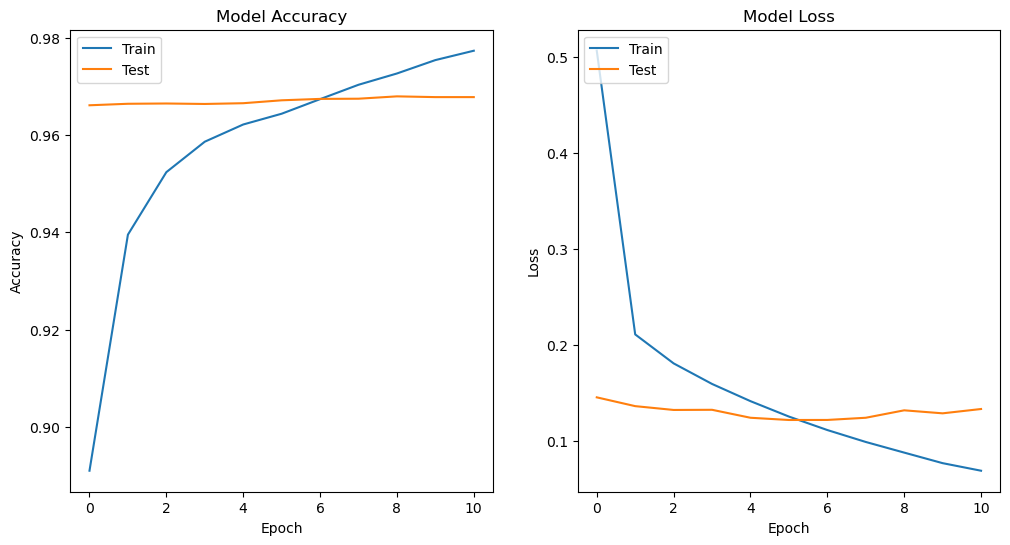

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [17]:
model.save('model1.h5')

/Users/dianasolfonseca/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from tensorflow.keras.models import load_model #to reload our model
# model = load_model('model1.h5')

Now we will evaluate our trained model on the test set and check the accuracy of the model.

In [18]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_scores[0]}")
print(f"Test Accuracy: {test_scores[1]}")
print(f"Test Precision: {test_scores[2]}")
print(f"Test Recall: {test_scores[3]}")

53/53 - 7s - loss: 0.1218 - accuracy: 0.9671 - precision: 0.6533 - recall: 0.0561 - 7s/epoch - 137ms/step
Test Loss: 0.12177721410989761
Test Accuracy: 0.9671434760093689
Test Precision: 0.653333306312561
Test Recall: 0.056064072996377945


Now we get the main classification metrics for the model:

In [19]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=mlb_genre.classes_))



53/53 [==============================] - 6s 110ms/step
                                         precision    recall  f1-score   support

                 Abstract Expressionism       0.00      0.00      0.00         3
                                Baroque       0.51      0.25      0.34        87
                          Byzantine Art       0.00      0.00      0.00        17
                                 Cubism       0.00      0.00      0.00        83
                      Early Renaissance       0.00      0.00      0.00        35
                          Expressionism       0.67      0.05      0.09        41
           Expressionism,Abstractionism       0.00      0.00      0.00        14
Expressionism,Abstractionism,Surrealism       0.00      0.00      0.00        37
                       High Renaissance       0.50      0.04      0.08       140
                          Impressionism       0.70      0.05      0.09       280
       Impressionism,Post-Impressionism       0.00   

/Users/dianasolfonseca/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dianasolfonseca/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


To get the information for each artist:

In [20]:
def load_artist_info(csv_path):
    artist_df = pd.read_csv(csv_path)
    artist_info = {}
    for index, row in artist_df.iterrows():
        # We normalize to handle special characters and spaces 
        artist_key = normalize_name(row['name']).replace(' ', '_')
        artist_info[artist_key] = {
            'name': row['name'],
            'genre': row['genre'],
            'nationality': row['nationality']
        }
    return artist_info

infos = load_artist_info('artists.csv')

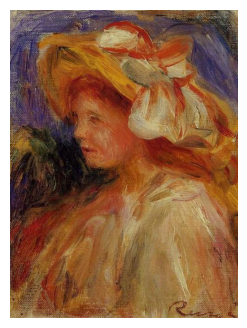

1/1 [==============================] - 0s 37ms/step
True genre well predicted!
Predicted genre: Impressionism
True genre: Impressionism


In [76]:
# random.seed(7)
index = random.randint(0, len(X_test) - 1)
image_path = os.path.join(images_directory, os.listdir(images_directory)[index])

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4, 4))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

def predict_single_image(model, image_path, mlb_genre, infos, threshold=0.45):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32")/255.0
    img = np.expand_dims(img, axis=0)
    
    #We get the right genre 
    artist_name = normalize_name(image_path.split('/')[-1].rsplit('_', 1)[0])
    true_genre = infos[artist_name]['genre']
    
    #Predictions
    prediction = model.predict(img)
    prediction_binary = (prediction > threshold).astype(int) 
    genre_labels = mlb_genre.inverse_transform(prediction_binary)
    pred_genre = genre_labels[0][0]
    if true_genre not in pred_genre:
        print("True genre not well predicted!")
    else:
        print("True genre well predicted!")
    
    return pred_genre, true_genre

genre_labels, true_genre = predict_single_image(model, image_path, mlb_genre,infos,  threshold=0.48)
print("Predicted genre:", genre_labels)
print("True genre:", true_genre)